# Full circuit for 1+1d SU(2) Trotter simulation using the LSH formulation with $L=4$, $\Lambda=2$

Using a qutrit to represent the bosonic dof at r=2.

Considering first-order Trotter for the moment.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.99'
import sys
sys.path.append('/home/iiyama/src/lsh-qudit')
import numpy as np
import scipy
import jax
import jax.numpy as jnp
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.transpiler import PassManager, StagedPassManager, generate_preset_pass_manager
from qiskit.quantum_info import Operator
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeKawasaki
import lsh_qudit.set_rccx_inverse
from lsh_qudit.constants import sigmaminus, sigmaplus, pauliz, paulii
from lsh_qudit.validator_jax import validate_circuit
from lsh_qudit.utils import QubitPlacement, sort_qubits, draw_circuit, clean_array, op_matrix
from lsh_qudit.hamiltonian import (BOSON_TRUNC, physical_states,
                                   mass_term_site, electric_12_term_site, electric_3f_term_site,
                                   electric_3b_term_site, hopping_term_site, hamiltonian)
from lsh_qudit.precompiler import lsh_qudit_precompiler
from lsh_qudit.postcompiler import LSHPostcompiler
from lsh_qudit.layout import layout_heavy_hex, layout_candidates
from lsh_qudit.transpiler import transpile_lsh_circuit

jax.config.update('jax_enable_x64', True)

## Model parameters

In [ ]:
num_sites = 4
mass_mu = Parameter('$\mu$')
interaction_x = Parameter('x')
time_step = Parameter('$\Delta$t')
# Random not-so-small numbers for numerical validation
dt = 0.73
mu = 0.37
x = 0.87

## $H_M$

$$
\begin{align*}
H_{M}(r) &= H_{M}^{(1)}(r) + H_{M}^{(2)}(r)\,, \\
H_{M}^{(1)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{i(r)}\,,\\
H_{M}^{(2)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{o(r)}\,
\end{align*}
$$

### Circuit

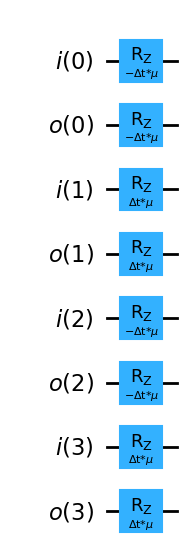

In [4]:
mass_qp = QubitPlacement(sum(([('i', site), ('o', site)] for site in range(4)), []))
mass_circuit = QuantumCircuit(mass_qp.num_qubits)
for site in range(4):
    circuit, init_p, _ = mass_term_site(site, time_step, mass_mu)
    mass_circuit.compose(circuit, qubits=[mass_qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(mass_circuit, mass_qp, reorder=False)

### Validation

In [5]:
assigned = sort_qubits(mass_circuit, mass_qp).assign_parameters({mass_mu: mu, time_step: dt})
op = np.zeros((2,) * (2 * num_sites))
for site in range(4):
    for io in range(2):
        dim = 2 * (4 - site) - io - 1
        extra_dims = list(range(dim)) + list(range(dim + 1, 8))
        op += np.expand_dims(np.array([1., -1.]) * (-1 + 2 * (site % 2)), extra_dims)
op *= mu / 2. * dt
hmat = np.diagflat(op)
validate_circuit(assigned, hmat, diagonal=True)

True

## $H_E$

$$
\begin{align}
H_{E}&=H_{E}^{(1)} + H_{E}^{(2)} + H_{E}^{(3)}
\\
H_{E}^{(1)} & = \frac{1}{2}n_{l}(r)\,,
\\
H_{E}^{(2)} & = \frac{1}{4}n_{l}(r)^{2}\,,
\\
H_{E}^{(3)} & = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)\,.
\end{align}
$$

### $H_E^{(1)} + H_E^{(2)} = \frac{1}{2}n_{l}(r) + \frac{1}{4}n_{l}(r)^{2}$ circuit

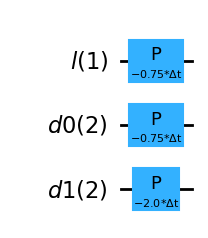

In [6]:
labels = [('l', 1), ('d0', 2), ('d1', 2)]
electric_12_qp = QubitPlacement(labels)
electric_12_circuit = QuantumCircuit(electric_12_qp.num_qubits)
for site, bc in enumerate([{'max_left_flux': 0}, {'max_left_flux': 1}, {}]):
    circuit, init_p, _ = electric_12_term_site(site, time_step, **bc)
    electric_12_circuit.compose(circuit, qubits=[electric_12_qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(electric_12_circuit, electric_12_qp, reorder=False, fold=100)

### $H_E^{(1)} + H_E^{(2)}$ validation

In [7]:
assigned = sort_qubits(electric_12_circuit, electric_12_qp).assign_parameters({time_step: dt})
op = np.zeros((4, 2))
op[:, 1] += 0.75
nl = np.arange(3)
op[:3] += (0.5 * nl + 0.25 * nl * nl)[:, None]
op *= dt
hmat = np.diagflat(op)
subspace_multi = np.unique(physical_states(max_left_flux=1, num_sites=2, as_multi=True)[:, [5, 2]], axis=0)
subspace = np.concatenate([(subspace_multi[:, 0, None] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 1:]], axis=1)
validate_circuit(assigned, hmat, boson_regs=[(1, 2)], subspace=tuple(subspace.T))

True

### $H_E^{(3)} = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)$ circuit

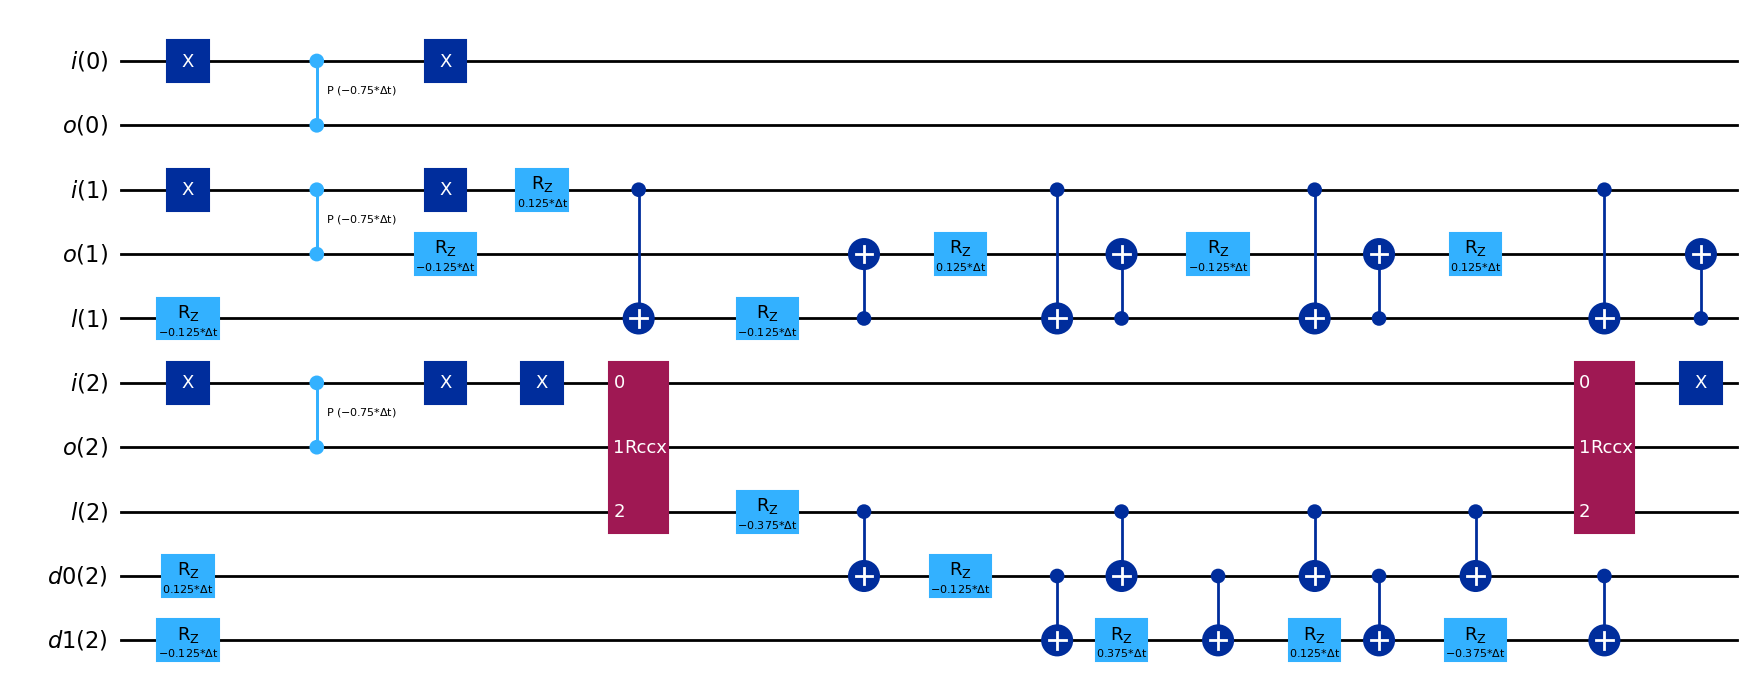

In [8]:
labels = [('o', 0), ('i', 0)]
labels += [('i', 1), ('l', 1), ('o', 1)]
labels += [('l', 2), ('o', 2), ('i', 2), ('d0', 2), ('d1', 2)]
electric_3_qp = QubitPlacement(labels)
electric_3_circuit = QuantumCircuit(electric_3_qp.num_qubits)
for site, bc in enumerate([{'max_left_flux': 0}, {'max_left_flux': 1}, {}]):
    circuit, init_p, _ = electric_3f_term_site(site, time_step)
    electric_3_circuit.compose(circuit, qubits=[electric_3_qp[lab] for lab in init_p.qubit_labels], inplace=True)
    circuit, init_p, _ = electric_3b_term_site(site, time_step, **bc)
    electric_3_circuit.compose(circuit, qubits=[electric_3_qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(electric_3_circuit, electric_3_qp, fold=100)

### $H_E^{(3)}$ validation

In [9]:
assigned = sort_qubits(electric_3_circuit, electric_3_qp).assign_parameters({time_step: dt})
op = np.zeros((4, 2, 2, 2, 2, 2, 2, 2))
op[:, :, :, :, :, :, 1, 0] += 0.75
op[:, :, :, :, 1, 0] += 0.75
op[:, :, :, 1, 1, 0] += 0.5
op[:, 1, 0] += 0.75
op[1, 1, 0] += 0.5
op[2, 1, 0] += 1.
op *= dt
hmat = np.diagflat(op)
subspace_multi = np.unique(physical_states(max_left_flux=0, num_sites=3, as_multi=True)[:, [8, 7, 6, 5, 4, 3, 1, 0]], axis=0)
subspace = np.concatenate([(subspace_multi[:, 0, None] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 1:]], axis=1)
validate_circuit(assigned, hmat, ancillae=(7,), boson_regs=[(8, 9)], subspace=tuple(subspace.T))

True

## $H_I$

In [10]:
from lsh_qudit.hamiltonian import hopping_term_config
configs = [hopping_term_config(ttype, site, max_left_flux=lflux, max_right_flux=rflux)
           for ttype, site, lflux, rflux in [(1, 0, 0, -1), (1, 1, 1, -1), (1, 2, -1, 1), (2, 0, 0, -1), (2, 1, 1, -1), (2, 2, -1, 1)]]

config_itr = iter(configs)
for ttype in [1, 2]:
    for site in range(3):
        config = next(config_itr)
        print(ttype, site, config.boson_ops['p'], config.boson_ops['q'])

1 0 ('id', 'id') ('X', 'zero')
1 1 ('X', 'zero') ('lambda', 'id')
1 2 ('lambda', 'id') ('X', 'zero')
2 0 ('X', 'zero') ('id', 'id')
2 1 ('lambda', 'id') ('X', 'zero')
2 2 ('X', 'zero') ('lambda', 'id')


### $H_I^{(1)}$

The general form of $H_I^{(1)}$ is

$$
\begin{split}
\frac{1}{x} H_I^{(1)}(r) = & H_I^{(1)+}(r) + H_I^{(1)-}(r) \\
= & \ket{0}\bra{1}_{i(r)} Z_{o(r)} \ket{1}\bra{0}_{i(r+1)} \left[ \lambda^+_{l(r)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \right]^{1 - n_o(r)} \left[ \lambda^+_{l(r+1)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \right]^{n_o(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right) \\
& + \ket{1}\bra{0}_{i(r)} Z_{o(r)} \ket{0}\bra{1}_{i(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right)
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \lambda^-_{l(r)} \right]^{1 - n_o(r)}
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \lambda^-_{l(r+1)} \right]^{n_o(r+1)}
\end{split}
$$

Note that the combinations of the allowed $n_i$ and $n_o$ values together with AGL dictates that a
non-annihilated state will have $n_l(r) = n_l(r+1)$.


In [11]:
hopping_shape = (4, 2, 2, 4, 2, 2)  # l(r+1), o(r+1), i(r+1), l(r), o(r), i(r)
diag_fn = np.sqrt((np.arange(4)[:, None, None] + np.arange(1, 3)[None, :, None])
                      / (np.arange(4)[:, None, None] + np.arange(1, 3)[None, None, :]))

cyc_incr = np.zeros((4, 4), dtype=np.complex128)
cyc_incr[[0, 1, 2], [2, 0, 1]] = 1.
incrp = cyc_incr @ np.diagflat([1., 1., 0., 0.])
cincrp = np.zeros((8, 8), dtype=np.complex128)
cincrp[:4, :4] = np.diagflat([1., 1., 1., 0.])
cincrp[4:, 4:] = incrp
ocincrp = np.zeros((8, 8), dtype=np.complex128)
ocincrp[:4, :4] = incrp
ocincrp[4:, 4:] = np.diagflat([1., 1., 1., 0.])
cx = np.eye(4, dtype=np.complex128)
cx[2:, 2:] = np.array([[0., 1.], [1., 0.]])
ocx = np.eye(4, dtype=np.complex128)
ocx[:2, :2] = np.array([[0., 1.], [1., 0.]])
hadamard = np.array([[1., 1.], [1., -1.]]) / np.sqrt(2.)
ccdecr = np.eye(16, dtype=np.complex128)
ccdecr[12:, 12:] = cyc_incr.conjugate().T
cocdecr = np.eye(16, dtype=np.complex128)
cocdecr[8:12, 8:12] = cyc_incr.conjugate().T
occdecr = np.eye(16, dtype=np.complex128)
occdecr[4:8, 4:8] = cyc_incr.conjugate().T
ococdecr = np.eye(16, dtype=np.complex128)
ococdecr[:4, :4] = cyc_incr.conjugate().T

hi1_mat = op_matrix(np.diagflat(diag_fn), hopping_shape, (2, 1, 4))
hi1_mat = op_matrix(cincrp, hopping_shape, (4, 5)) @ hi1_mat
hi1_mat = op_matrix(ocincrp, hopping_shape, (1, 2)) @ hi1_mat
hi1_mat = op_matrix(sigmaminus, hopping_shape, 3) @ hi1_mat
hi1_mat = op_matrix(pauliz, hopping_shape, 1) @ hi1_mat
hi1_mat = op_matrix(sigmaplus, hopping_shape, 0) @ hi1_mat
hi1_mat += hi1_mat.conjugate().T

hi1usvd_yp_mat = op_matrix(cocdecr, hopping_shape, (3, 1, 2))
hi1usvd_yp_mat = op_matrix(ccdecr, hopping_shape, (3, 4, 5)) @ hi1usvd_yp_mat
hi1usvd_yp_mat = op_matrix(cx, hopping_shape, (3, 0)) @ hi1usvd_yp_mat
hi1usvd_yp_mat = op_matrix(hadamard, hopping_shape, 3) @ hi1usvd_yp_mat

hi1usvd_xp_mat = op_matrix(ococdecr, hopping_shape, (0, 1, 2))
hi1usvd_xp_mat = op_matrix(occdecr, hopping_shape, (0, 4, 5)) @ hi1usvd_xp_mat
hi1usvd_xp_mat = op_matrix(ocx, hopping_shape, (0, 3)) @ hi1usvd_xp_mat
hi1usvd_xp_mat = op_matrix(hadamard, hopping_shape, 0) @ hi1usvd_xp_mat

#### $r=0$ circuit

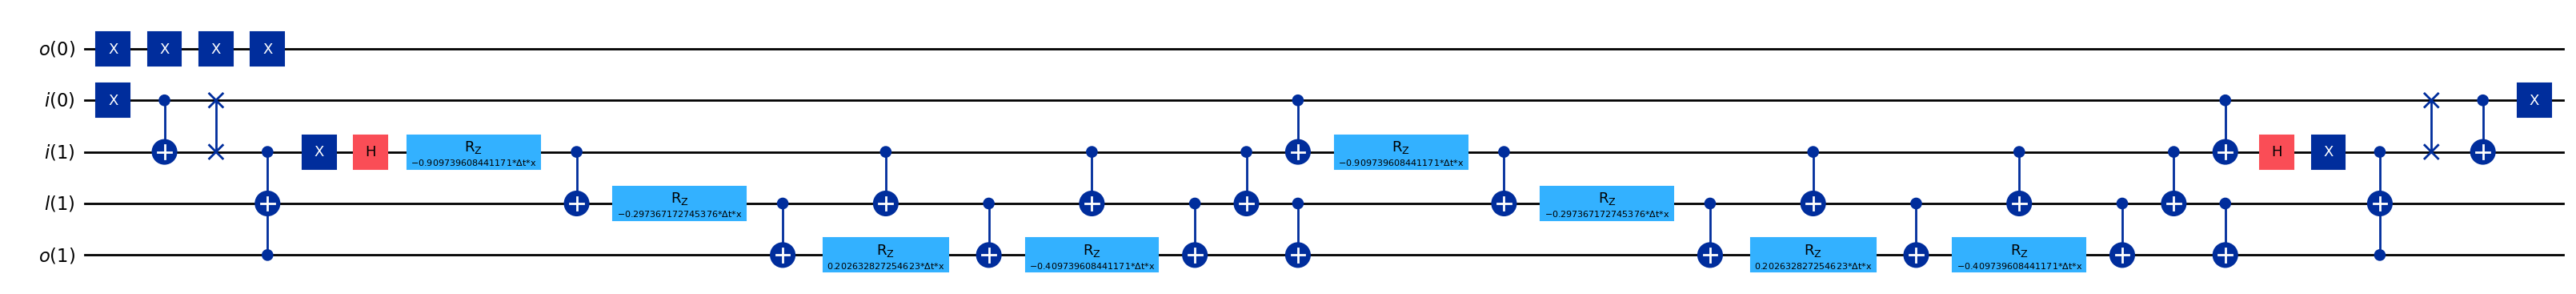

In [12]:
circuit, init_p, _ = hopping_term_site(1, 0, time_step, interaction_x, max_left_flux=0)
draw_circuit(circuit, init_p, reorder=False, fold=60)

#### $r=0$ validation

In [13]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
embedded_qp = QubitPlacement([('i', 0), ('o', 0), ('l', 0), ('i', 1), ('o', 1), ('l', 1)])
embedded = QuantumCircuit(embedded_qp.num_qubits)
embedded.compose(assigned, qubits=[embedded_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(4, 4, 4, 4, 4, 4, 4, 4)[:2, :, :2, :, :2, :, :2, :].reshape(64, 64) * x * dt
subspace = physical_states(max_left_flux=0, num_sites=2, as_multi=True)[:, ::-1]
validate_circuit(embedded, hmat, subspace=tuple(subspace.T))

True

#### $r=1$ circuit

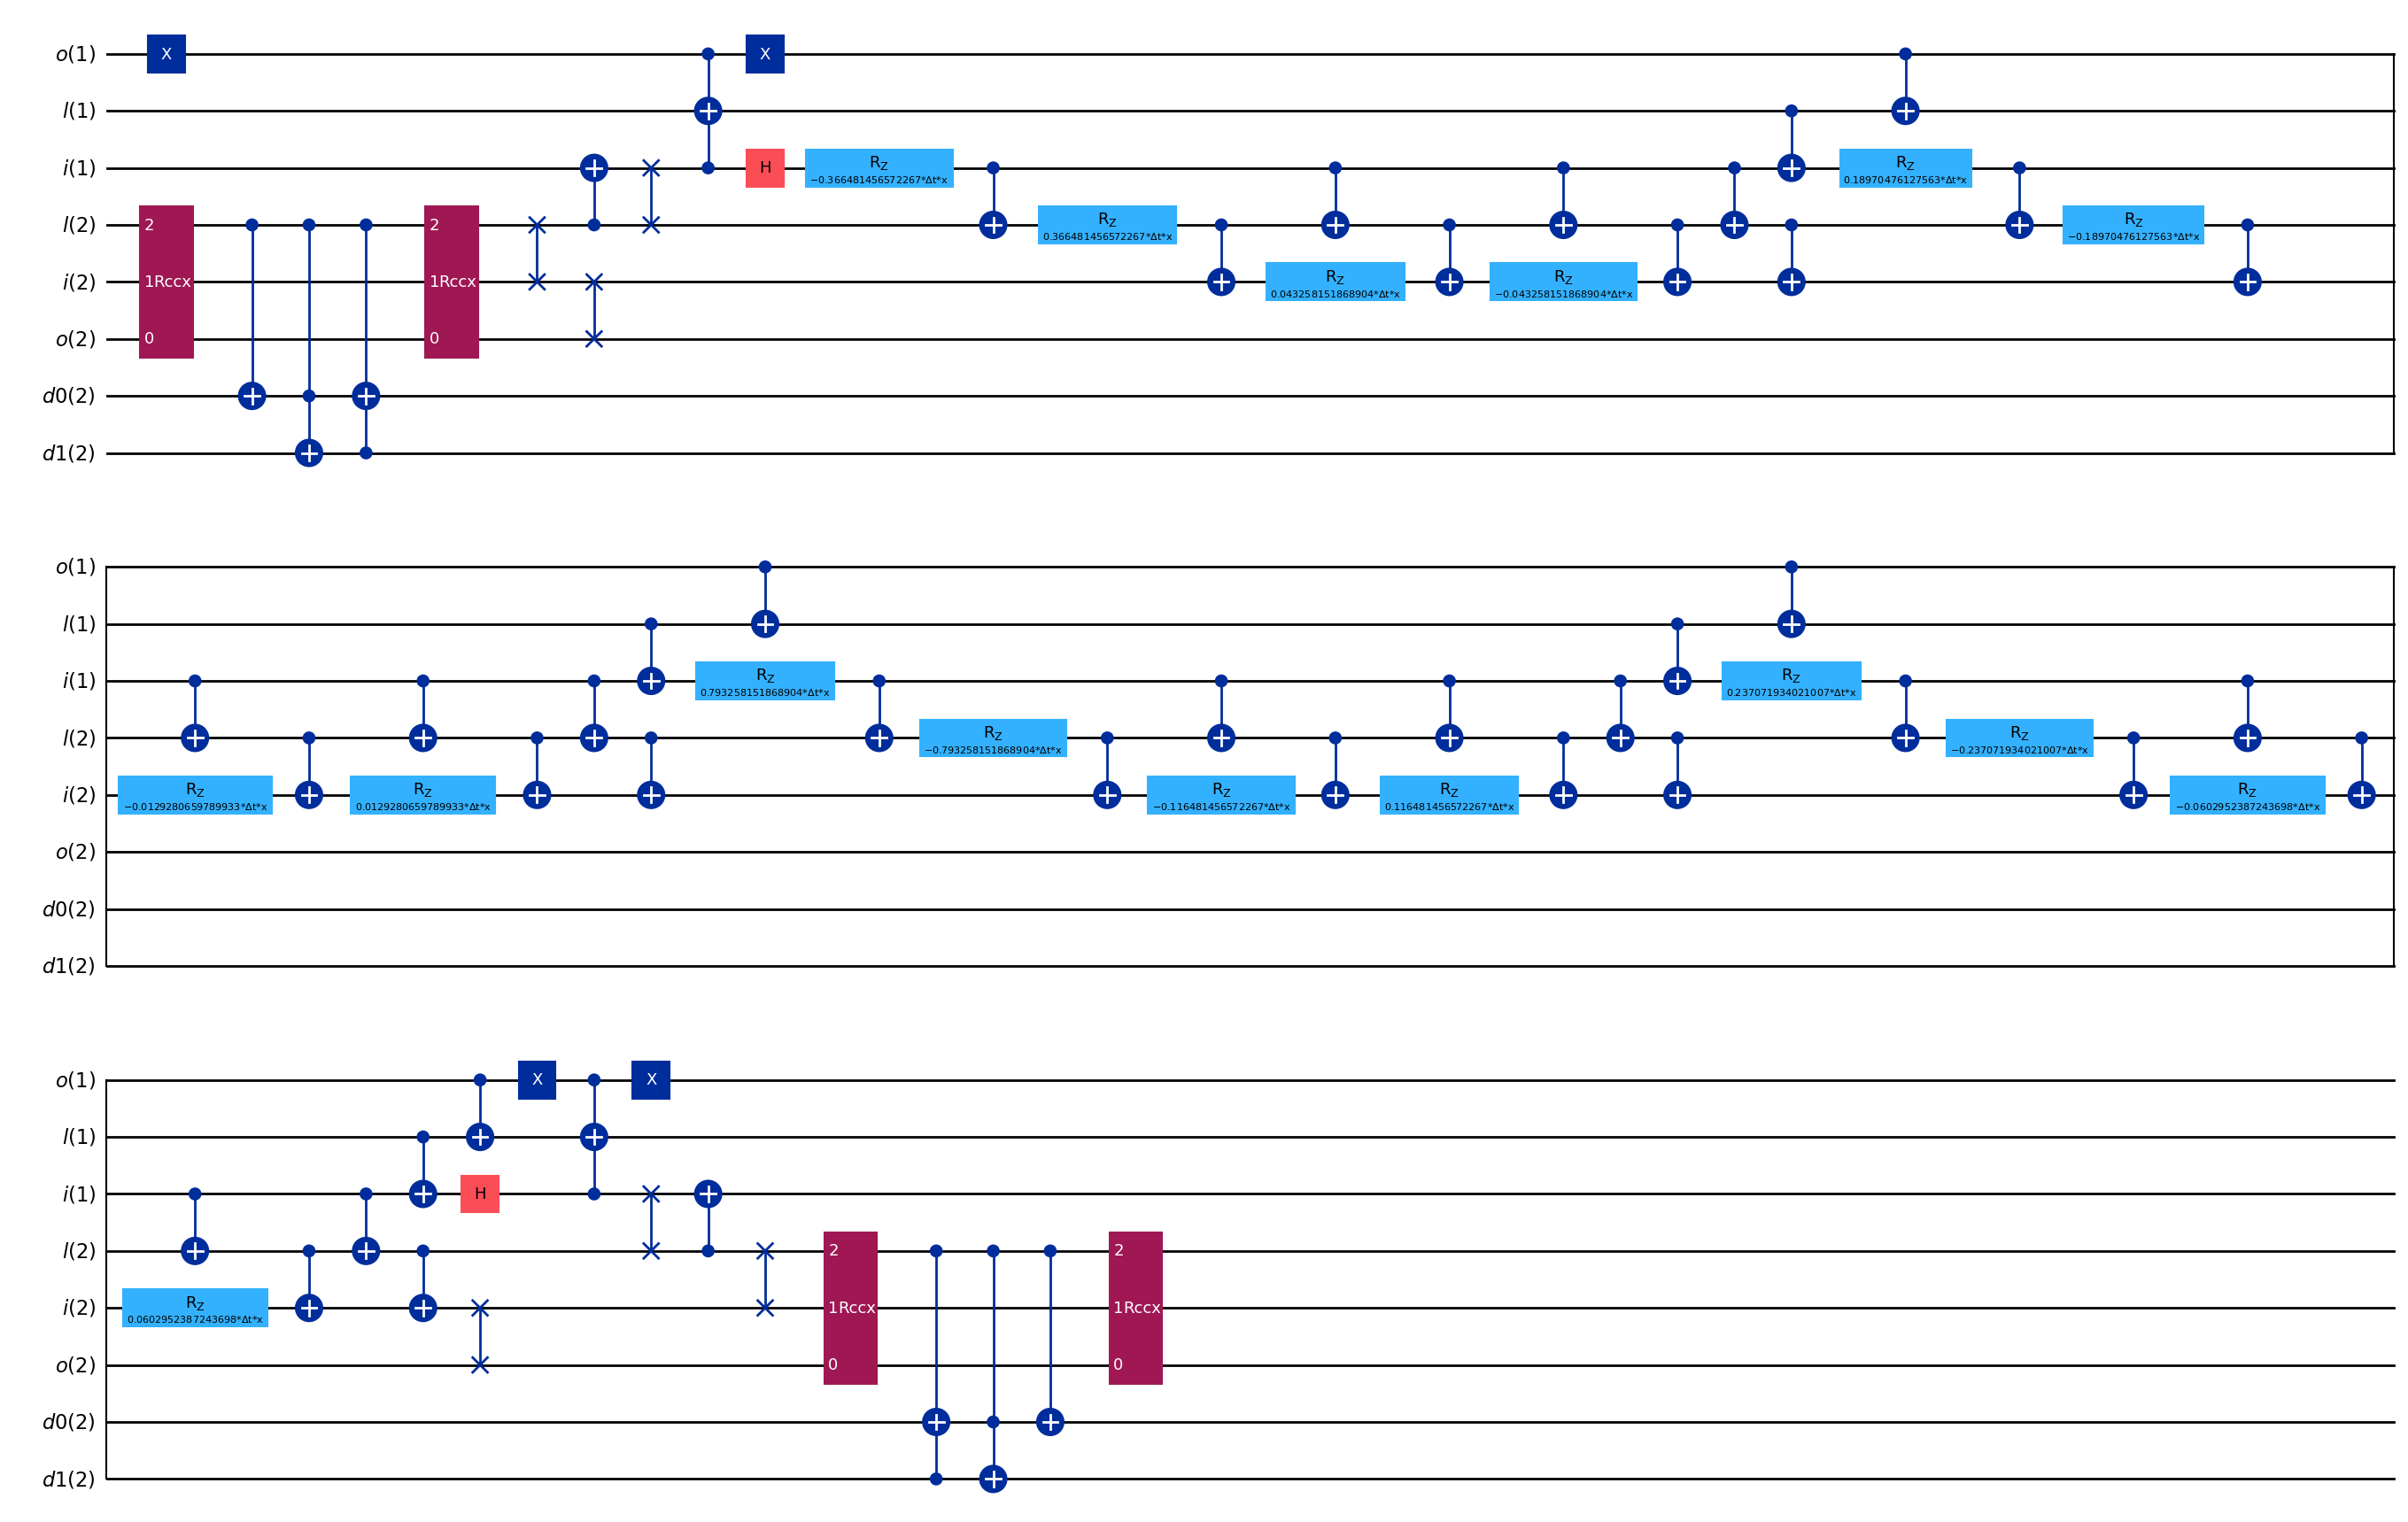

In [14]:
circuit, init_p, _ = hopping_term_site(1, 1, time_step, interaction_x, max_left_flux=1)
draw_circuit(circuit, init_p, reorder=False, fold=40)

#### $r=1$ validation

In [15]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('i', 1), ('o', 1), ('l', 1), ('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(16, 4, 4, 16, 4, 4)[:, :2, :, :, :2, :].reshape(128, 128) * x * dt
subspace_multi = physical_states(max_left_flux=1, num_sites=2, as_multi=True)[:, ::-1]
subspace = np.concatenate([(subspace_multi[:, :1] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 1:]], axis=1)
validate_circuit(ordered, hmat, ancillae=(5,), boson_regs=[(6, 7)], subspace=tuple(subspace.T))

True

#### $r=2$ circuit

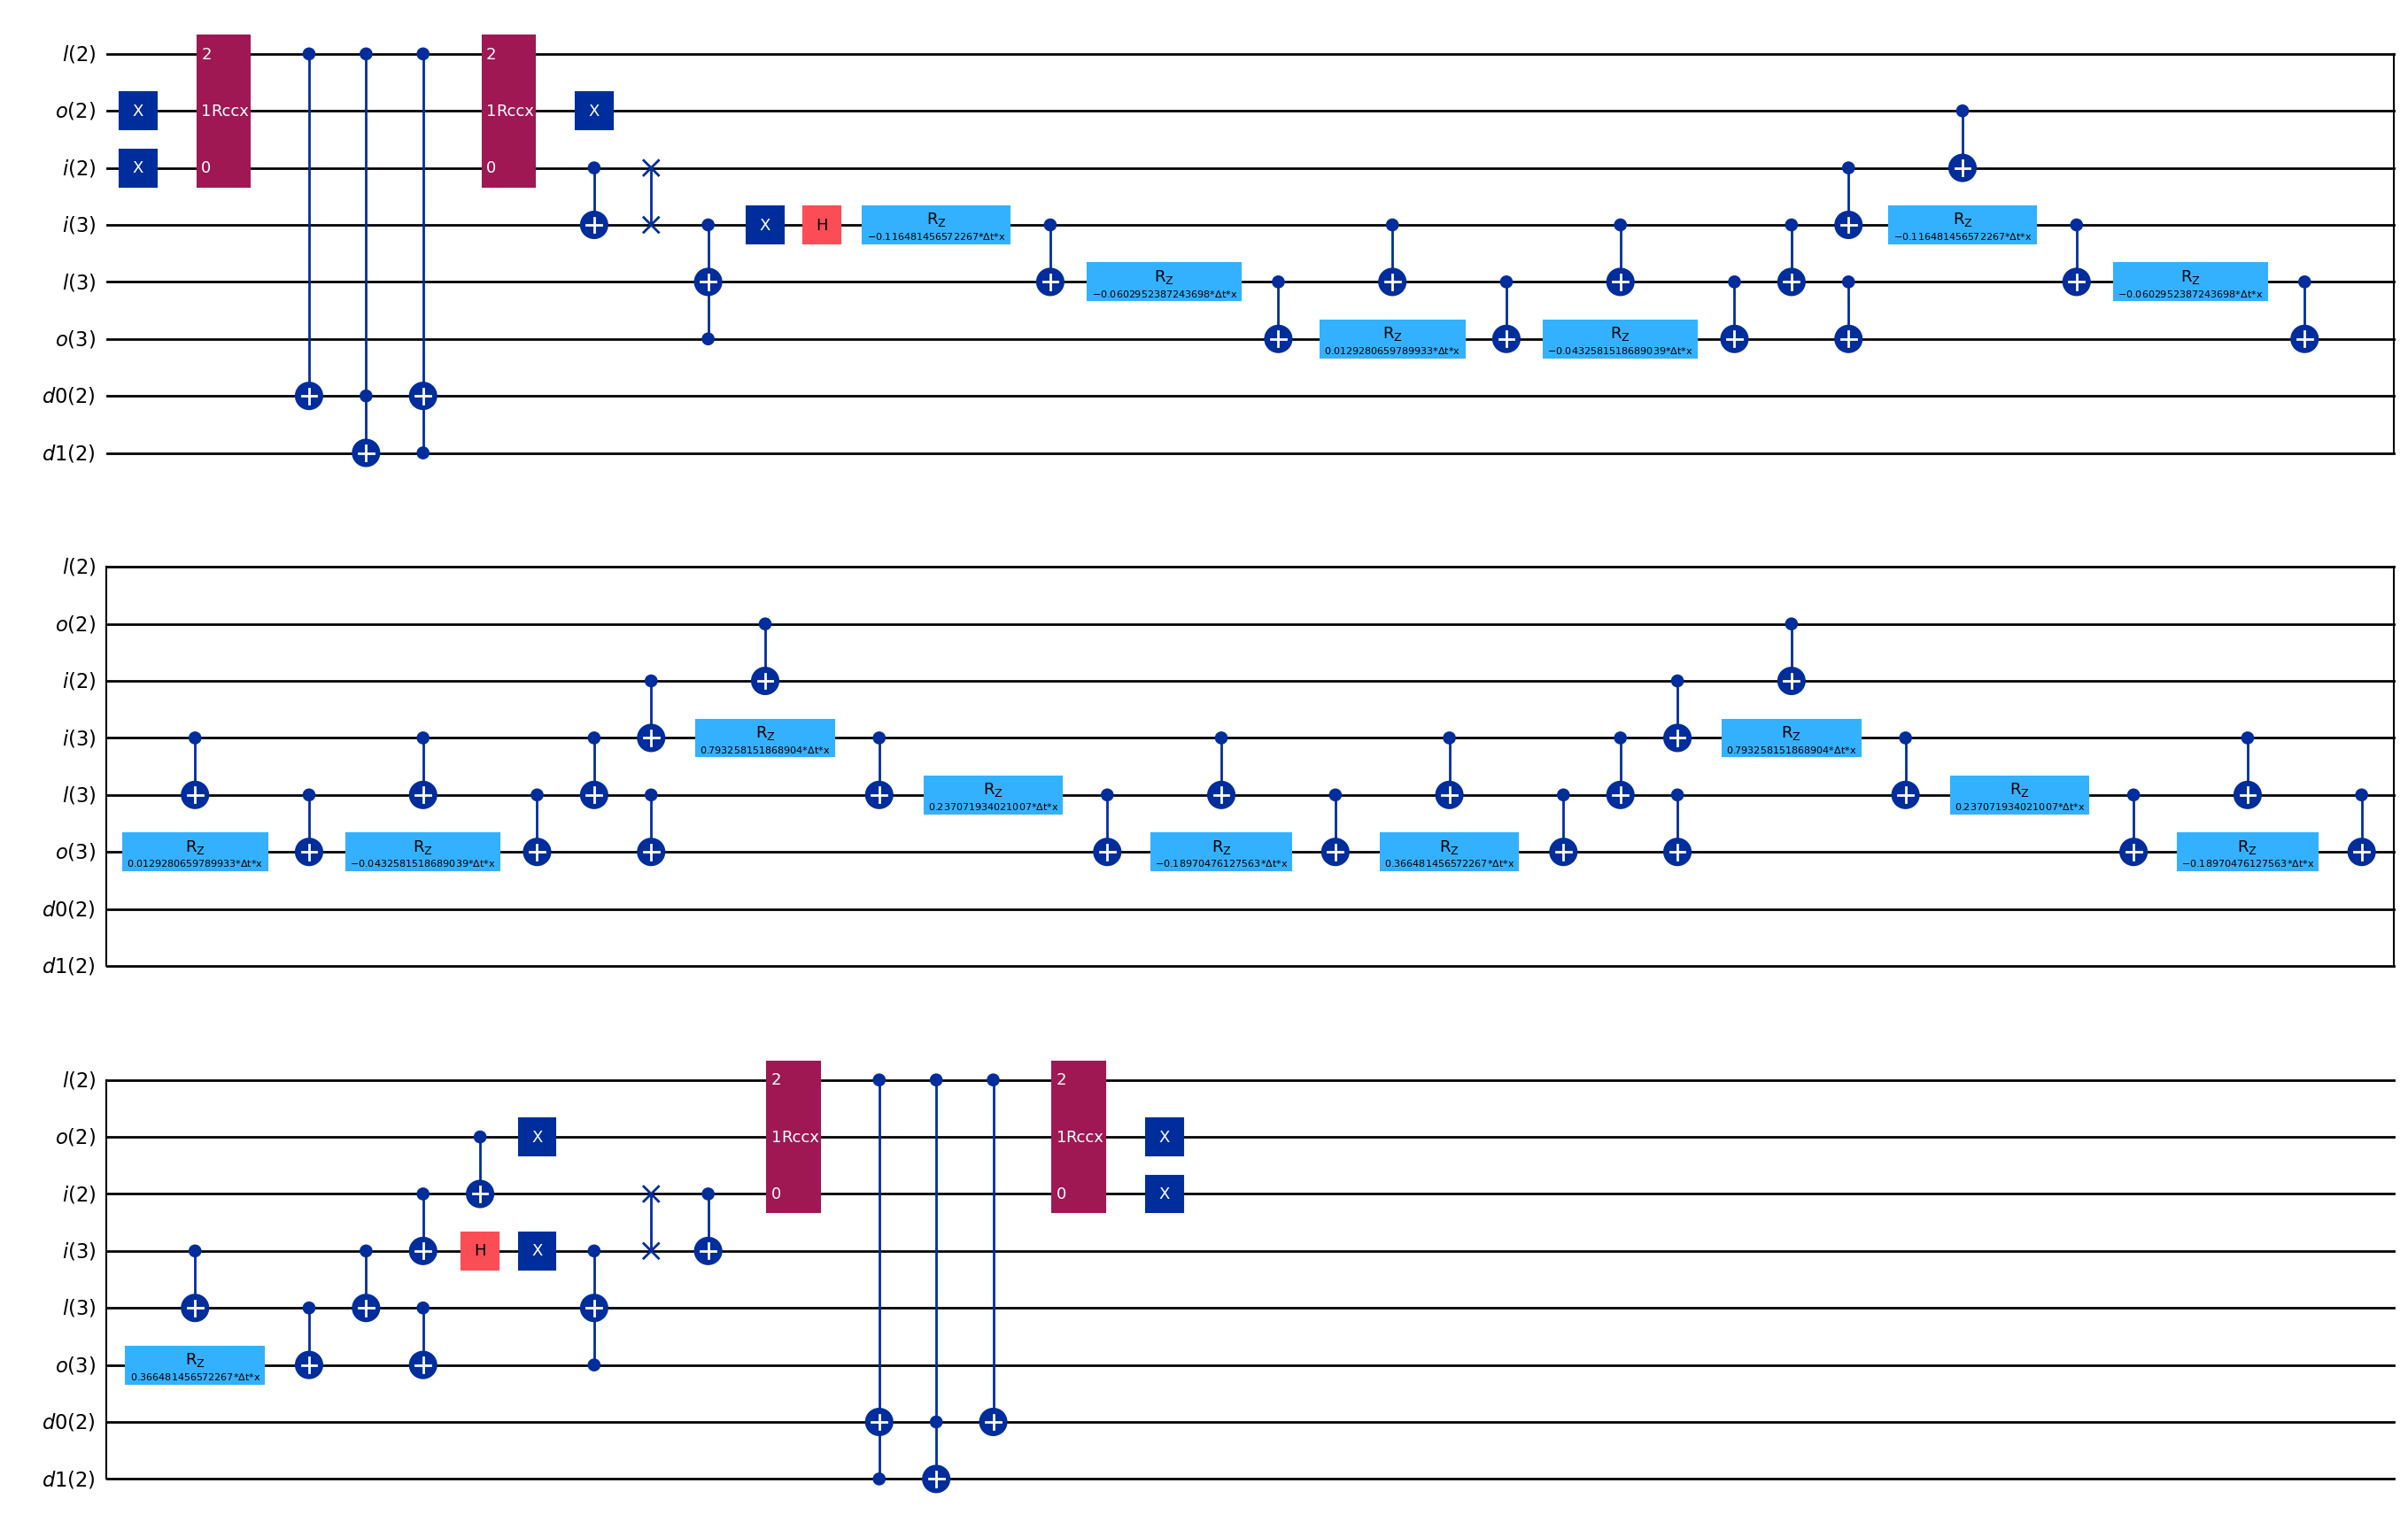

In [16]:
circuit, init_p, _ = hopping_term_site(1, 2, time_step, interaction_x, max_right_flux=1)
draw_circuit(circuit, init_p, reorder=False, fold=40)

#### $r=2$ validation

In [17]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2), ('i', 3), ('o', 3), ('l', 3)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(4, 4, 16, 4, 4, 16)[:2, :, :, :2, :, :].reshape(128, 128) * x * dt
subspace_multi = physical_states(max_right_flux=1, num_sites=2, as_multi=True)[:, ::-1]
subspace = np.concatenate([subspace_multi[:, :3], (subspace_multi[:, 3:4] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 4:]], axis=1)
validate_circuit(ordered, hmat, ancillae=(2,), boson_regs=[(6, 7)], subspace=tuple(subspace.T))

True

### $H_I^{(2)}$

In [18]:
hi2_mat = op_matrix(np.diagflat(diag_fn), hopping_shape, (5, 3, 0))
hi2_mat = op_matrix(cincrp, hopping_shape, (0, 2)) @ hi2_mat
hi2_mat = op_matrix(ocincrp, hopping_shape, (3, 5)) @ hi2_mat
hi2_mat = op_matrix(sigmaminus, hopping_shape, 1) @ hi2_mat
hi2_mat = op_matrix(pauliz, hopping_shape, 3) @ hi2_mat
hi2_mat = op_matrix(sigmaplus, hopping_shape, 4) @ hi2_mat
hi2_mat += hi2_mat.conjugate().T

#### $r=0$ circuit

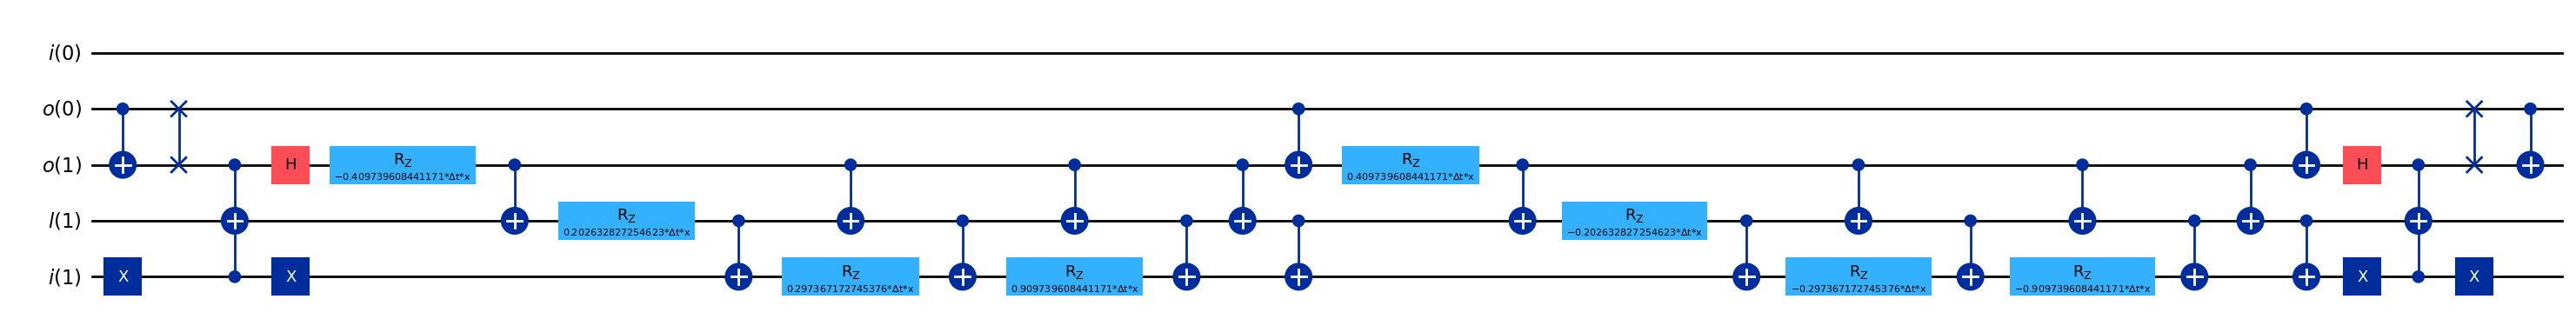

In [19]:
circuit, init_p, _ = hopping_term_site(2, 0, interaction_x, time_step, max_left_flux=0)
draw_circuit(circuit, init_p, reorder=False, fold=100)

#### $r=0$ validation

In [20]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
embedded_qp = QubitPlacement([('i', 0), ('o', 0), ('l', 0), ('i', 1), ('o', 1), ('l', 1)])
embedded = QuantumCircuit(embedded_qp.num_qubits)
embedded.compose(assigned, qubits=[embedded_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(4, 4, 4, 4, 4, 4, 4, 4)[:2, :, :2, :, :2, :, :2, :].reshape(64, 64) * x * dt
subspace = physical_states(max_left_flux=0, num_sites=2, as_multi=True)[:, ::-1]
validate_circuit(embedded, hmat, subspace=tuple(subspace.T))

True

#### $r=1$ circuit

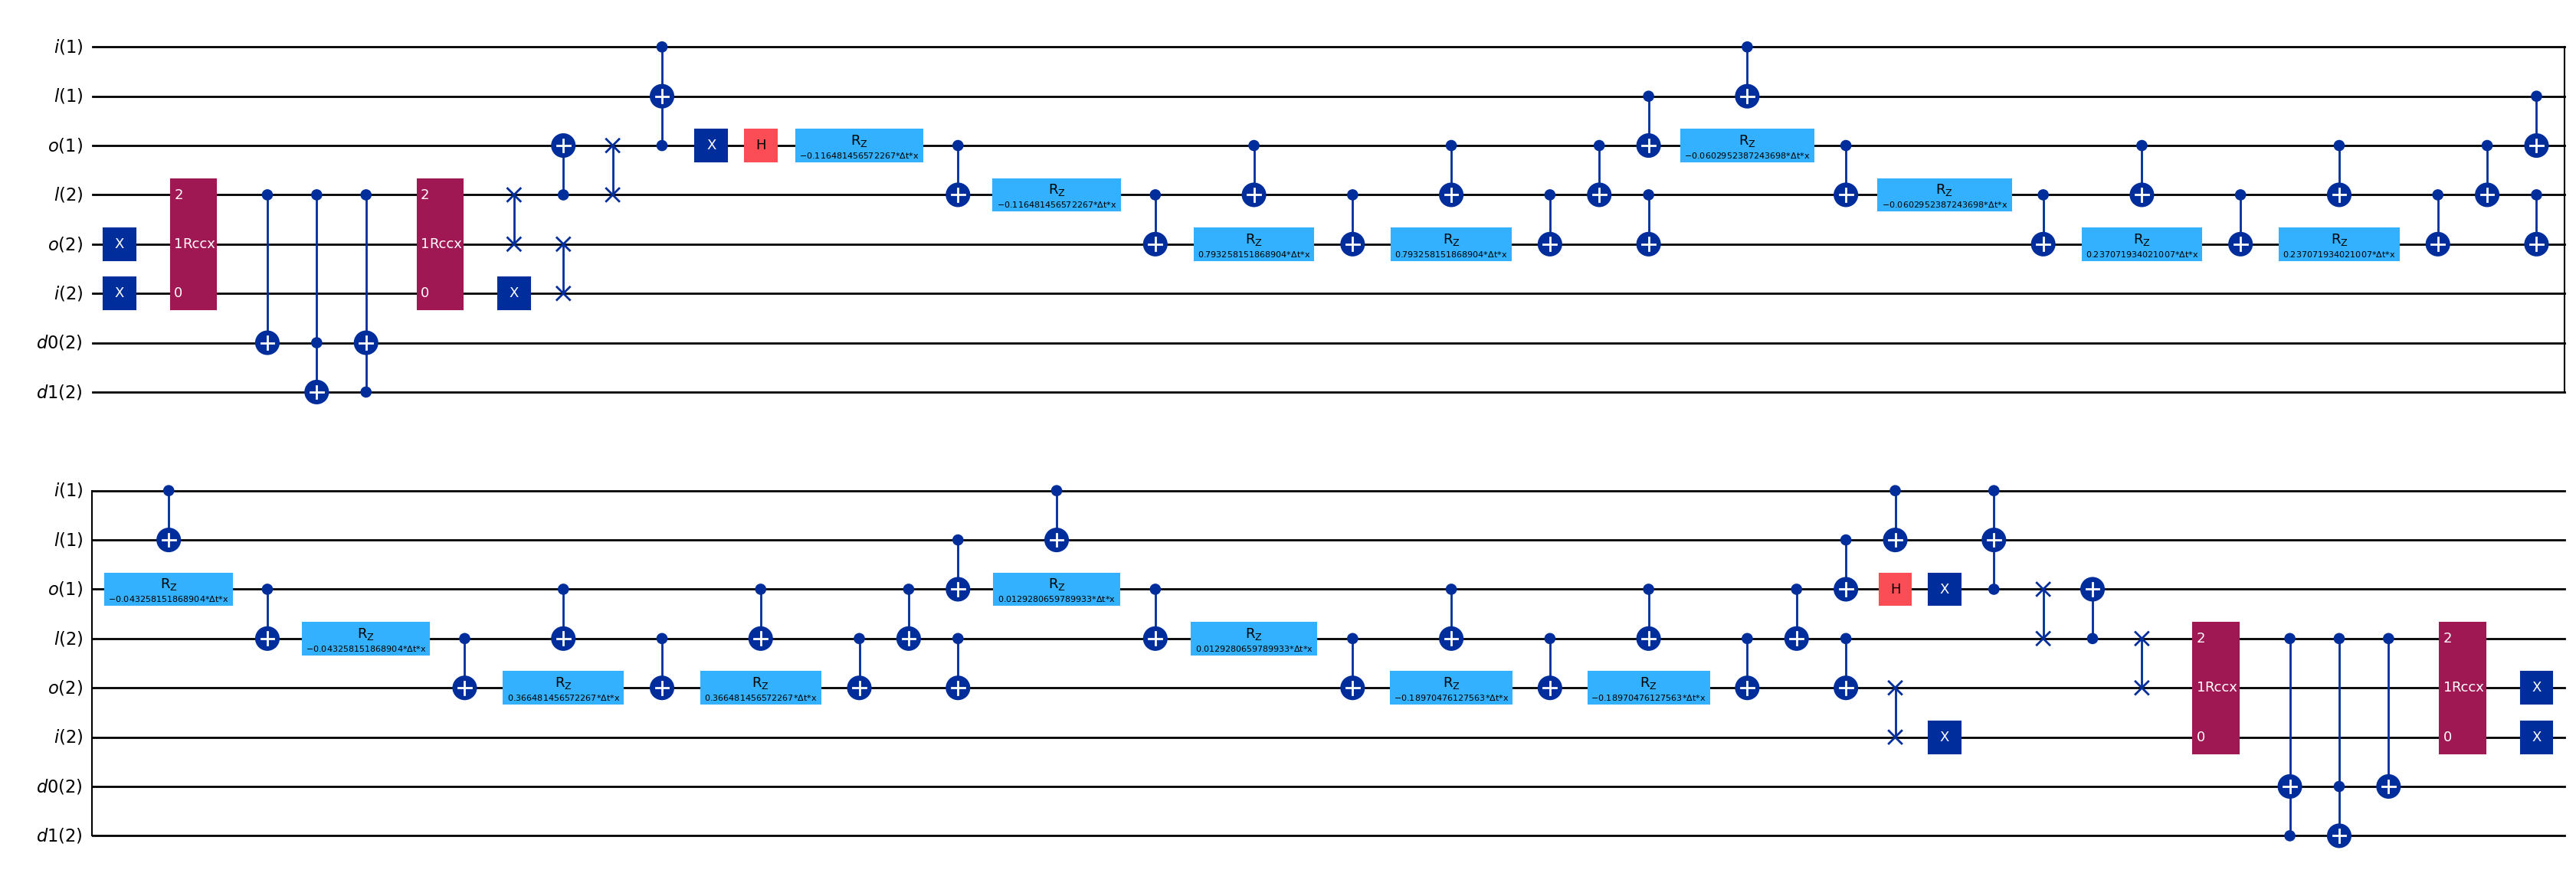

In [21]:
circuit, init_p, _ = hopping_term_site(2, 1, time_step, interaction_x, max_left_flux=1)
draw_circuit(circuit, init_p, reorder=False, fold=50)

#### $r=1$ validation

In [22]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('i', 1), ('o', 1), ('l', 1), ('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(16, 4, 4, 16, 4, 4)[:, :2, :, :, :2, :].reshape(128, 128) * x * dt
subspace_multi = physical_states(max_left_flux=1, num_sites=2, as_multi=True)[:, ::-1]
subspace = np.concatenate([(subspace_multi[:, :1] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 1:]], axis=1)
validate_circuit(ordered, hmat, ancillae=(5,), boson_regs=[(6, 7)], subspace=tuple(subspace.T))

True

#### $r=2$ circuit

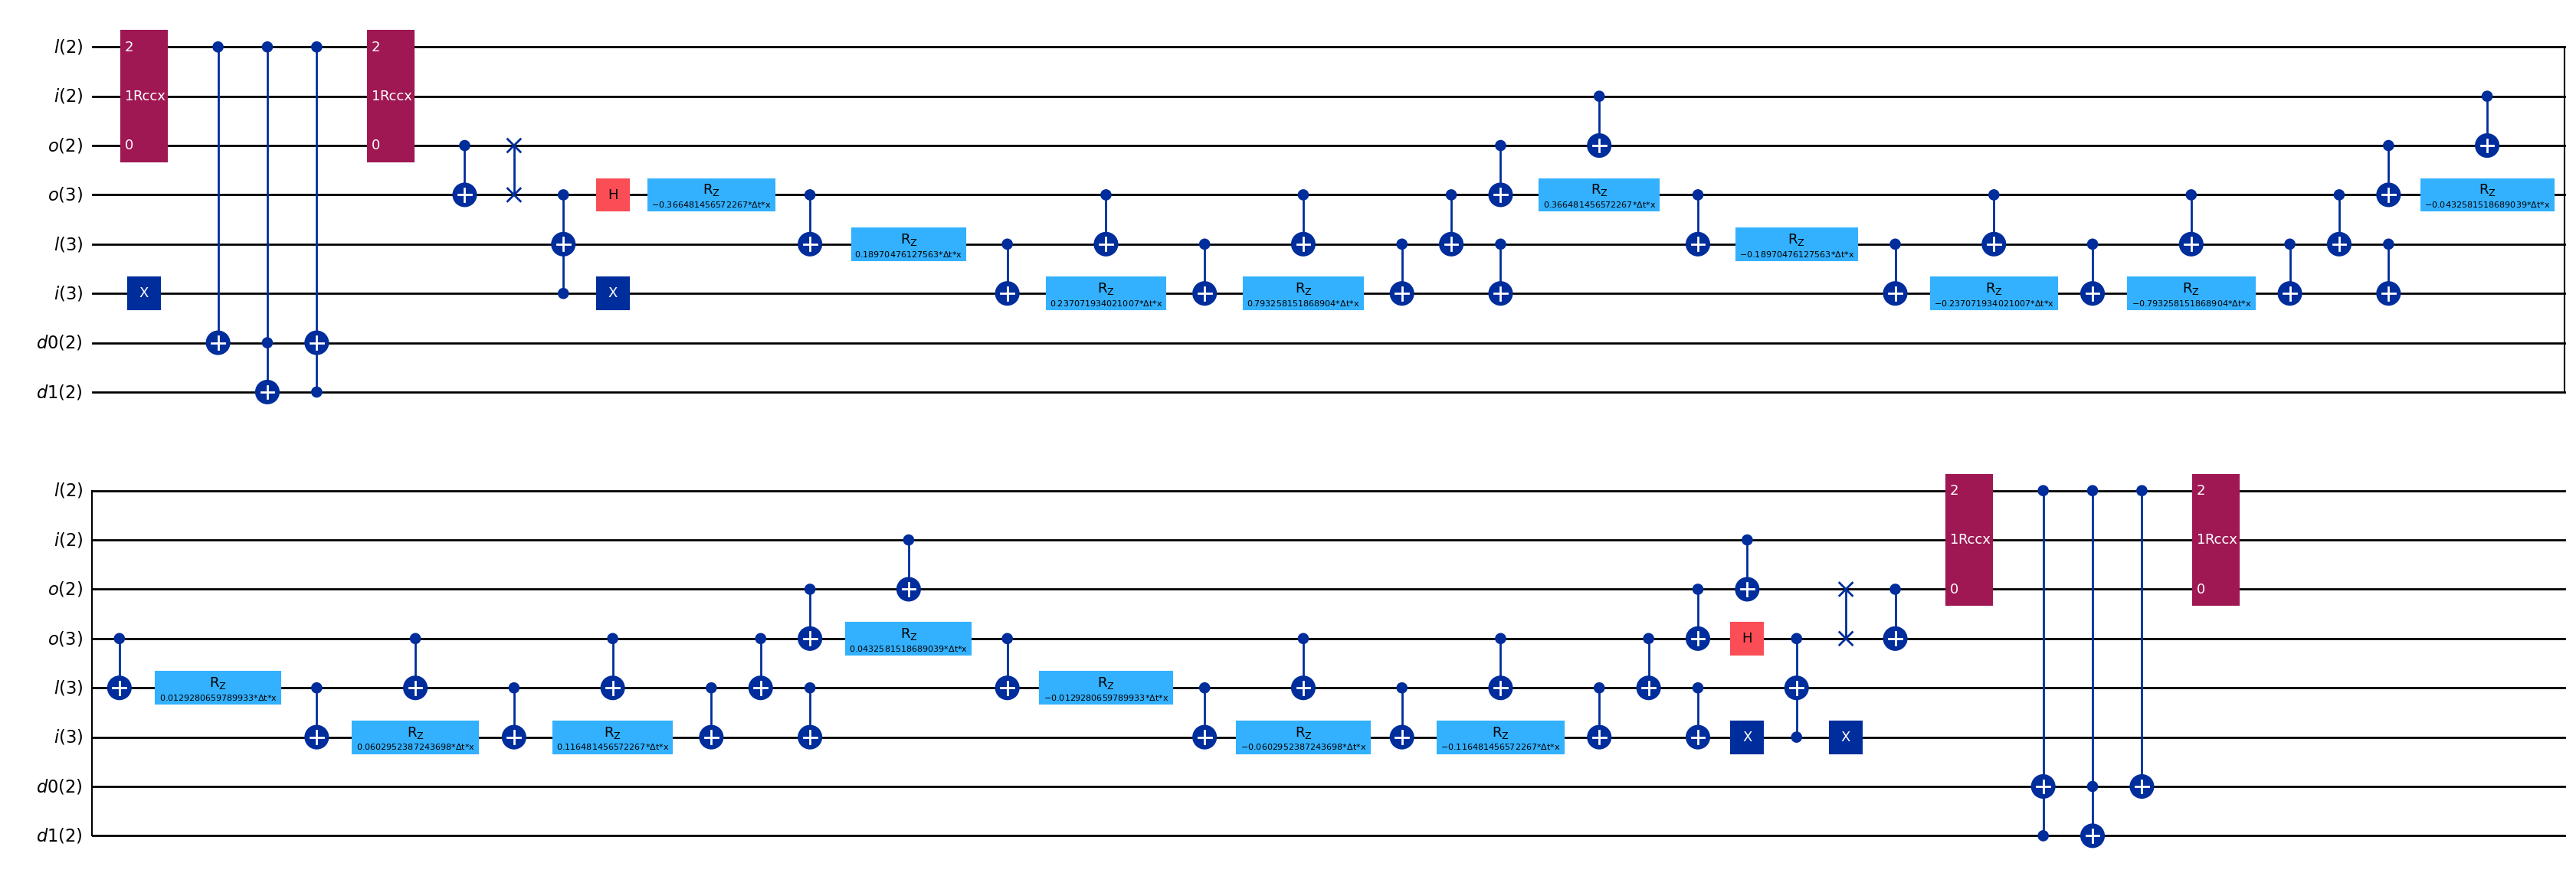

In [23]:
circuit, init_p, _ = hopping_term_site(2, 2, time_step, interaction_x, max_right_flux=1)
draw_circuit(circuit, init_p, reorder=False, fold=50)

#### $r=2$ validation

In [24]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2), ('i', 3), ('o', 3), ('l', 3)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(4, 4, 16, 4, 4, 16)[:2, :, :, :2, :, :].reshape(128, 128) * x * dt
subspace_multi = physical_states(max_right_flux=1, num_sites=2, as_multi=True)[:, ::-1]
subspace = np.concatenate([subspace_multi[:, :3], (subspace_multi[:, 3:4] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 4:]], axis=1)
validate_circuit(ordered, hmat, ancillae=(2,), boson_regs=[(6, 7)], subspace=tuple(subspace.T))

True

## Full Hamiltonian (first-order Trotter)

### Circuit

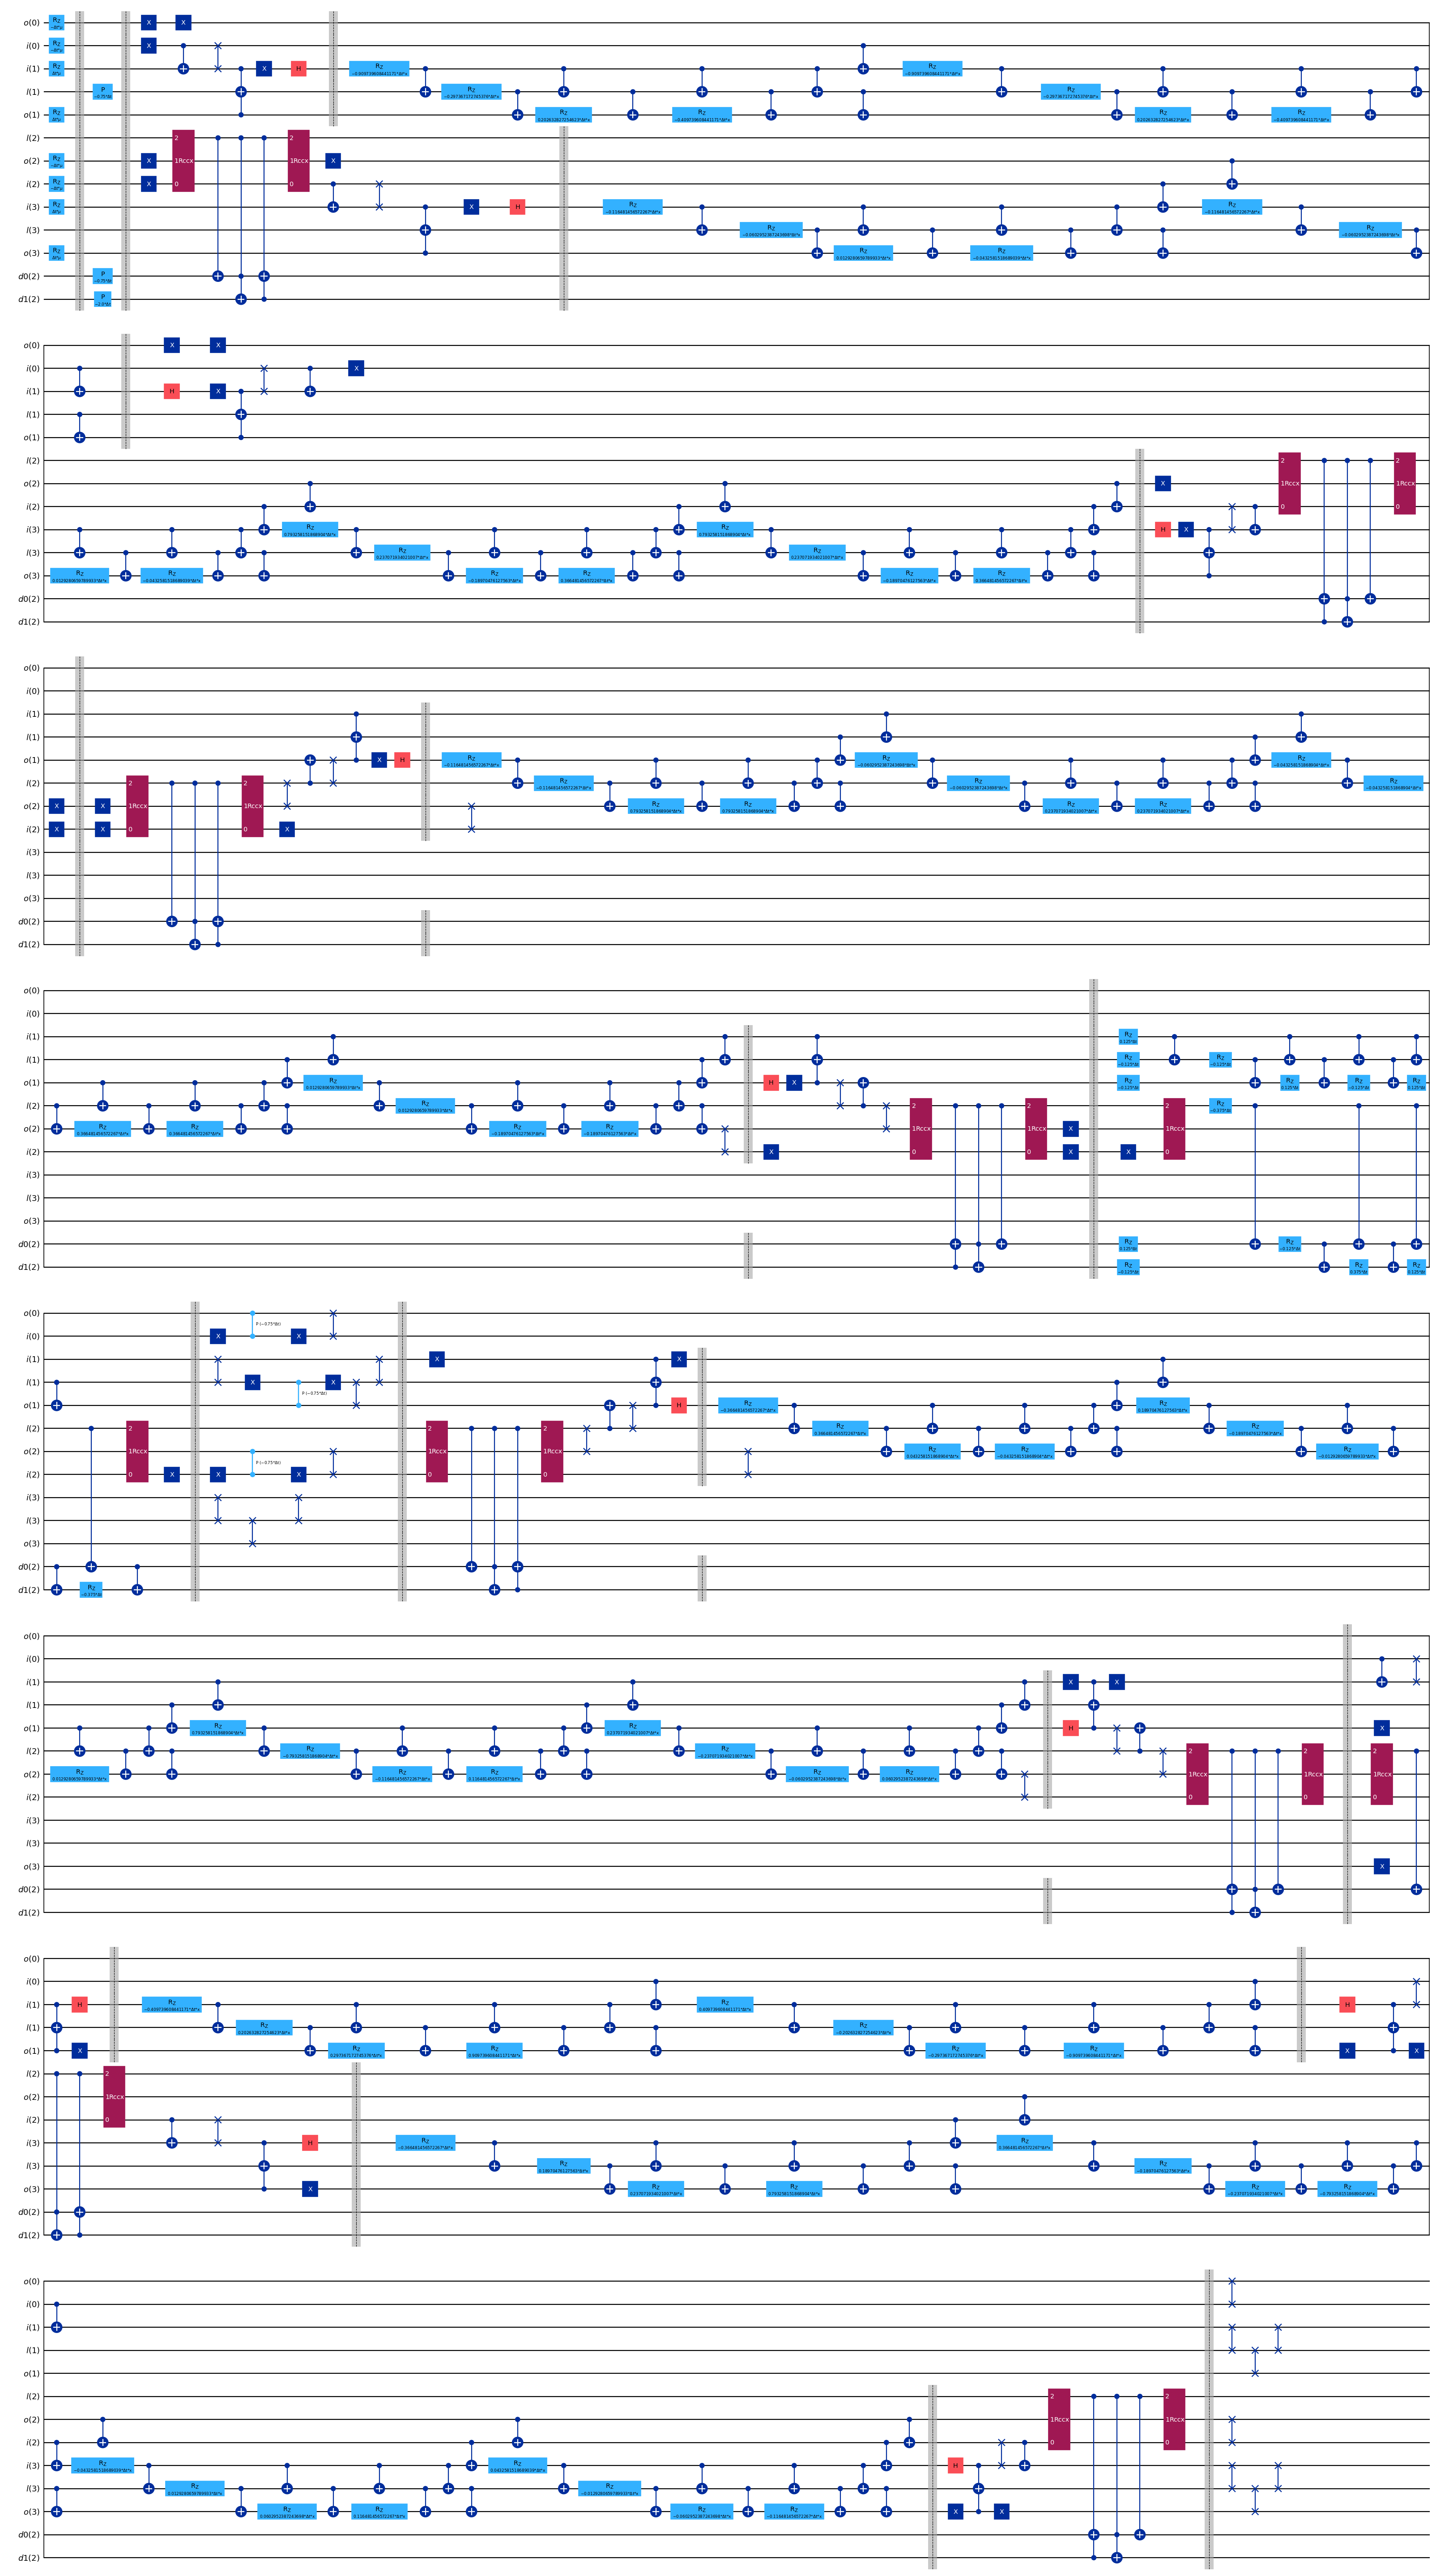

In [25]:
full_qp = QubitPlacement(
    [('o', 0), ('i', 0)]
    + [('i', 1), ('l', 1), ('o', 1)]
    + [('l', 2), ('o', 2), ('i', 2)]
    + [('i', 3), ('l', 3), ('o', 3)]
    + [('d0', 2), ('d1', 2)]
)
full_circuit = hamiltonian(4, time_step, mass_mu, interaction_x, qp=full_qp,
                           max_left_flux=0, max_right_flux=1, with_barrier=True)[0]
draw_circuit(full_circuit, full_qp, reorder=False, scale=0.8, fold=60)

In [26]:
precompile_pm = lsh_qudit_precompiler()
precompiled = precompile_pm.run(full_circuit)
precompiled.count_ops()

OrderedDict([('cx', 504),
             ('rz', 251),
             ('h', 60),
             ('x', 30),
             ('t', 20),
             ('tdg', 20),
             ('p', 3)])

In [27]:
# draw_circuit(precompiled, full_qp, reorder=False, scale=0.8, fold=60)

### Validation

In [28]:
assigned = precompiled.assign_parameters({interaction_x: x, time_step: dt, mass_mu: mu})
# assigned = precompiled.assign_parameters({time_step: dt, mass_mu: mu})
# assigned = precompiled.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement(
    [('i', 0), ('o', 0), ('l', 0)]
    + [('i', 1), ('o', 1), ('l', 1)]
    + [('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2)]
    + [('i', 3), ('o', 3), ('l', 3)]
)
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in full_qp.qubit_labels], inplace=True)

shape = (2, 2, 2) + (4, 2, 2) + (2, 2, 2) + (2, 2, 2)
ancillae = (8,)
boson_regs = [(9, 10)]

umat = jnp.eye(np.prod(shape), dtype=np.complex128)

# HM
op = np.zeros((2,) * (2 * num_sites))
um_even = np.diagflat(np.exp(1.j * np.array([1., -1.]) * mu / 2. * dt))
um_odd = np.diagflat(np.exp(-1.j * np.array([1., -1.]) * mu / 2. * dt))
for site in range(0, 4, 2):
    for io in range(2):
        umat = op_matrix(um_even, shape, 3 * site + io, npmod=jnp) @ umat
for site in range(1, 4, 2):
    for io in range(2):
        umat = op_matrix(um_odd, shape, 3 * site + io, npmod=jnp) @ umat

# HE[12]
op = np.zeros((4, 2))
op[:, 1] += 0.75
nl = np.arange(3)
op[:3] += (0.5 * nl + 0.25 * nl * nl)[:, None]
op *= dt
umat = op_matrix(np.diagflat(np.exp(-1.j * op)), shape, [8, 5], npmod=jnp) @ umat

# HI[1](0)
hmat = hi1_mat.reshape(4, 4, 4, 4, 4, 4, 4, 4)[:2, :, :2, :, :2, :, :2, :].reshape(64, 64) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(5, -1, -1)), npmod=jnp) @ umat
# HI[1](2)
hmat = hi1_mat.reshape(4, 4, 16, 4, 4, 16)[:2, :, :, :2, :, :].reshape(128, 128) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(11, 5, -1)), npmod=jnp) @ umat
# HI[2](1)
hmat = hi2_mat.reshape(16, 4, 4, 16, 4, 4)[:, :2, :, :, :2, :].reshape(128, 128) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(8, 2, -1)), npmod=jnp) @ umat

# HE[3]
op = np.zeros((4, 2, 2, 2, 2, 2, 2, 2))
op[:, :, :, :, :, :, 1, 0] += 0.75
op[:, :, :, :, 1, 0] += 0.75
op[:, :, :, 1, 1, 0] += 0.5
op[:, 1, 0] += 0.75
op[1, 1, 0] += 0.5
op[2, 1, 0] += 1.
op *= dt
umat = op_matrix(np.diagflat(np.exp(-1.j * op)), shape, list(range(8, 2, -1)) + [1, 0], npmod=jnp) @ umat

# HI[1](1)
hmat = hi1_mat.reshape(16, 4, 4, 16, 4, 4)[:, :2, :, :, :2, :].reshape(128, 128) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(8, 2, -1)), npmod=jnp) @ umat
# HI[2](0)
hmat = hi2_mat.reshape(4, 4, 4, 4, 4, 4, 4, 4)[:2, :, :2, :, :2, :, :2, :].reshape(64, 64) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(5, -1, -1)), npmod=jnp) @ umat
# HI[2](2)
hmat = hi2_mat.reshape(4, 4, 16, 4, 4, 16)[:2, :, :, :2, :, :].reshape(128, 128) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(11, 5, -1)), npmod=jnp) @ umat

subspace_multi = physical_states(max_left_flux=0, max_right_flux=1, num_sites=4, as_multi=True)[:, ::-1]
subspace = np.concatenate([subspace_multi[:, :3], (subspace_multi[:, 3:4] >> np.array([[1, 0]])) % 2, subspace_multi[:, 4:]], axis=1)
validate_circuit(ordered, umat, ancillae=ancillae, boson_regs=boson_regs, exponentiate=False, subspace=tuple(subspace.T))

True

## Full Hamiltonian (second-order Trotter)

### Circuit (op count)

In [29]:
full_qp = QubitPlacement(
    [('o', 0), ('i', 0)]
    + [('i', 1), ('l', 1), ('o', 1)]
    + [('l', 2), ('o', 2), ('i', 2)]
    + [('i', 3), ('l', 3), ('o', 3)]
    + [('d0', 2), ('d1', 2)]
)
full_circuit = hamiltonian(4, time_step, mass_mu, interaction_x, qp=full_qp,
                           max_left_flux=0, max_right_flux=1, with_barrier=True, second_order=True)[0]
precompile_pm = lsh_qudit_precompiler()
precompiled = precompile_pm.run(full_circuit)
precompiled.count_ops()

OrderedDict([('cx', 810),
             ('rz', 422),
             ('h', 94),
             ('x', 50),
             ('t', 32),
             ('tdg', 32),
             ('p', 6)])

### Validation

In [30]:
assigned = precompiled.assign_parameters({interaction_x: x, time_step: dt, mass_mu: mu})
# assigned = precompiled.assign_parameters({time_step: dt, mass_mu: mu})
# assigned = precompiled.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement(
    [('i', 0), ('o', 0), ('l', 0)]
    + [('i', 1), ('o', 1), ('l', 1)]
    + [('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2)]
    + [('i', 3), ('o', 3), ('l', 3)]
)
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in full_qp.qubit_labels], inplace=True)

shape = (2, 2, 2) + (4, 2, 2) + (2, 2, 2) + (2, 2, 2)
full_dim = np.prod(shape)
ancillae = (8,)
boson_regs = [(9, 10)]

# HM
op = np.zeros((2,) * (2 * num_sites))
um_even = np.diagflat(np.exp(1.j * np.array([1., -1.]) * mu / 2. * dt * 0.5))
um_odd = np.diagflat(np.exp(-1.j * np.array([1., -1.]) * mu / 2. * dt * 0.5))
umass = jnp.eye(full_dim, dtype=np.complex128)
for site in range(0, 4, 2):
    for io in range(2):
        umass = op_matrix(um_even, shape, 3 * site + io, npmod=jnp) @ umass
for site in range(1, 4, 2):
    for io in range(2):
        umass = op_matrix(um_odd, shape, 3 * site + io, npmod=jnp) @ umass

# HE[12]
op = np.zeros((4, 2))
op[:, 1] += 0.75
nl = np.arange(3)
op[:3] += (0.5 * nl + 0.25 * nl * nl)[:, None]
op *= dt * 0.5
uele12 = op_matrix(np.diagflat(np.exp(-1.j * op)), shape, [8, 5], npmod=jnp)

# HI[1](0)
hmat = hi1_mat.reshape(4, 4, 4, 4, 4, 4, 4, 4)[:2, :, :2, :, :2, :, :2, :].reshape(64, 64) * x * dt * 0.5
uhi10 = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(5, -1, -1)), npmod=jnp)
# HI[1](2)
hmat = hi1_mat.reshape(4, 4, 16, 4, 4, 16)[:2, :, :, :2, :, :].reshape(128, 128) * x * dt * 0.5
uhi12 = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(11, 5, -1)), npmod=jnp)
# HI[2](1)
hmat = hi2_mat.reshape(16, 4, 4, 16, 4, 4)[:, :2, :, :, :2, :].reshape(128, 128) * x * dt * 0.5
uhi21 = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(8, 2, -1)), npmod=jnp)

# HE[3]
op = np.zeros((4, 2, 2, 2, 2, 2, 2, 2))
op[:, :, :, :, :, :, 1, 0] += 0.75
op[:, :, :, :, 1, 0] += 0.75
op[:, :, :, 1, 1, 0] += 0.5
op[:, 1, 0] += 0.75
op[1, 1, 0] += 0.5
op[2, 1, 0] += 1.
op *= dt * 0.5
uele3 = op_matrix(np.diagflat(np.exp(-1.j * op)), shape, list(range(8, 2, -1)) + [1, 0], npmod=jnp)

# HI[1](1)
hmat = hi1_mat.reshape(16, 4, 4, 16, 4, 4)[:, :2, :, :, :2, :].reshape(128, 128) * x * dt * 0.5
uhi11 = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(8, 2, -1)), npmod=jnp)
# HI[2](0)
hmat = hi2_mat.reshape(4, 4, 4, 4, 4, 4, 4, 4)[:2, :, :2, :, :2, :, :2, :].reshape(64, 64) * x * dt * 0.5
uhi20 = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(5, -1, -1)), npmod=jnp)
# HI[2](2)
hmat = hi2_mat.reshape(4, 4, 16, 4, 4, 16)[:2, :, :, :2, :, :].reshape(128, 128) * x * dt * 0.5
uhi22 = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(11, 5, -1)), npmod=jnp)

umat = umass @ uele12 @ uhi10 @ uhi12 @ uhi21 @ uele3 @ uhi11 @ uhi20 @ uhi22
umat @= uhi22 @ uhi20 @ uhi11 @ uele3 @ uhi21 @ uhi12 @ uhi10 @ uele12 @ umass

subspace_multi = physical_states(max_left_flux=0, max_right_flux=1, num_sites=4, as_multi=True)[:, ::-1]
subspace = np.concatenate([subspace_multi[:, :3], (subspace_multi[:, 3:4] >> np.array([[1, 0]])) % 2, subspace_multi[:, 4:]], axis=1)
validate_circuit(ordered, umat, ancillae=ancillae, boson_regs=boson_regs, exponentiate=False, subspace=tuple(subspace.T))

True

## Transpilation

In [31]:
backend = FakeTorino()

full_qp = QubitPlacement(
    [('o', 0), ('i', 0)]
    + [('i', 1), ('l', 1), ('o', 1)]
    + [('l', 2), ('o', 2), ('i', 2)]
    + [('i', 3), ('l', 3), ('o', 3)]
    + [('d0', 2), ('d1', 2)]
)
full_circuit = hamiltonian(4, time_step, mass_mu, interaction_x, qp=full_qp,
                           max_left_flux=0, max_right_flux=1, with_barrier=True)[0]
transpiled = transpile_lsh_circuit(full_circuit, full_qp, backend)
transpiled.count_ops()

OrderedDict([('rz', 1056), ('sx', 882), ('cz', 498), ('x', 9), ('z', 2)])

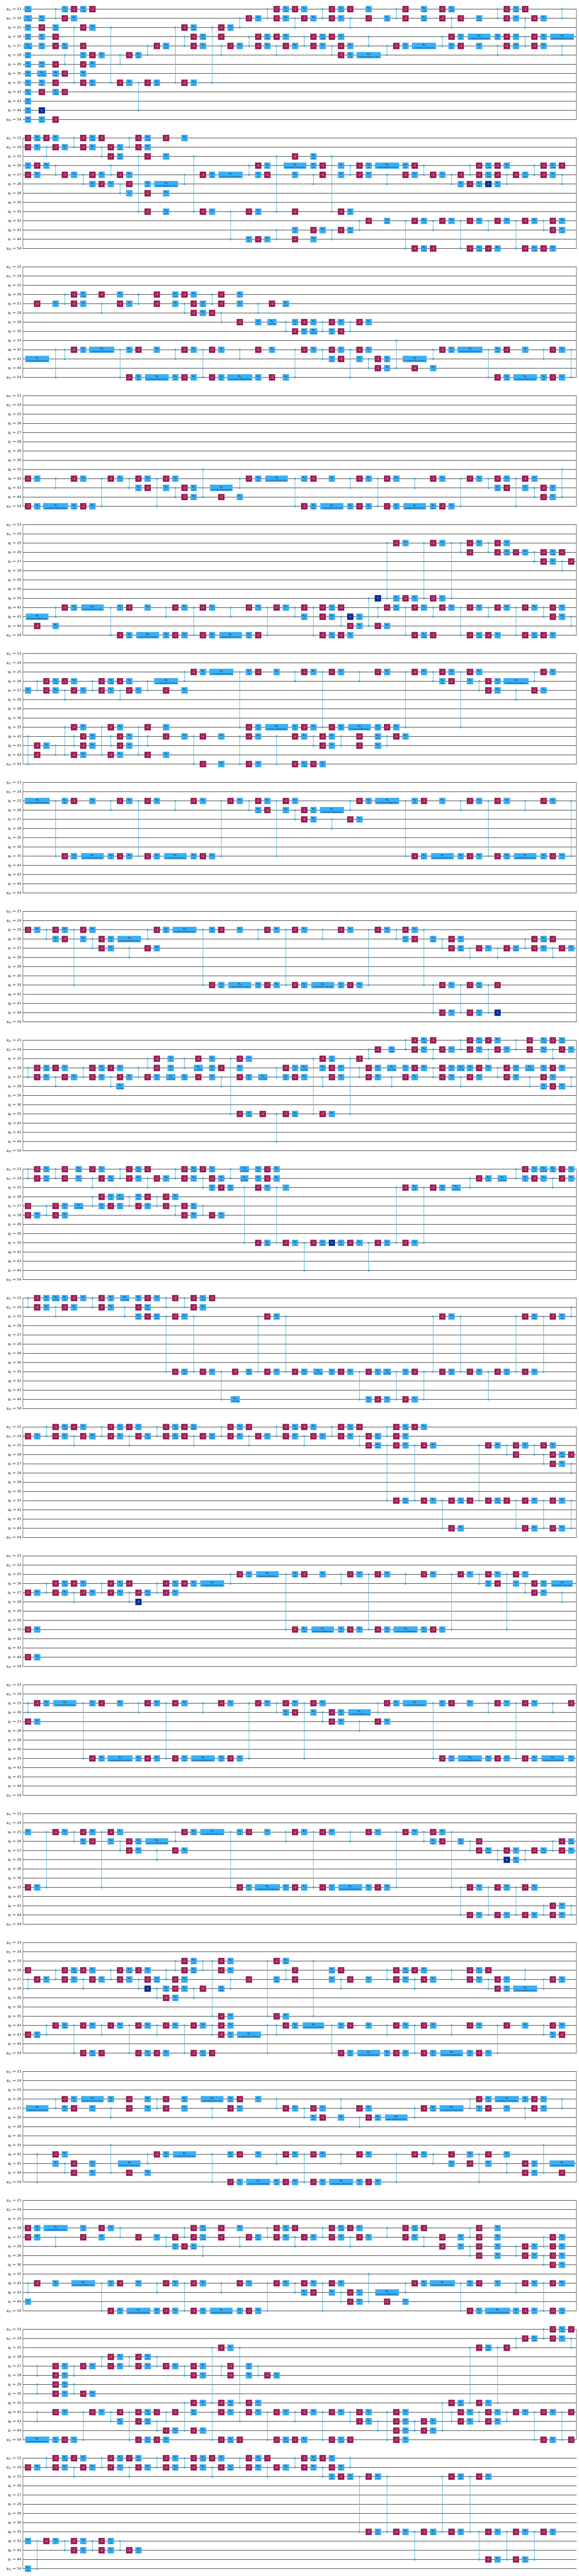

In [32]:
transpiled.draw('mpl', idle_wires=False, scale=0.8, fold=60)

### Validating the postcompiler

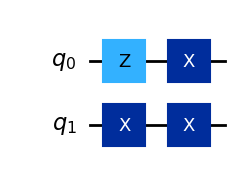

In [34]:
circuit = QuantumCircuit(2)
circuit.cz(0, 1)
circuit.x(1)
circuit.cz(0, 1)
circuit.cx(0, 1)
circuit.x(0)
circuit.cx(0, 1)

postcompile_pm = PassManager([LSHPostcompiler()])
postcompiled = postcompile_pm.run(circuit)
postcompiled.draw('mpl')

In [35]:
d = Operator(circuit.compose(postcompiled.inverse())).data
np.allclose(d * d[0, 0].conjugate(), np.eye(4))

True